---
---

# DRAFT: Clustar: Automated Star Clustering Analysis

---

---


- Project leverages clustering techniques to automate the detection and analysis of variable stars and transients
- Main challenge is that: Millions of stars observed in modern surveys generate terabytes of data daily
- Main benefit of project is that: Enhance understanding of stellar evolution and galactic dynamics
- Dataset is from NASA Exoplanet Science Institute, providing rich photometric and light curve data for this specific period: Date: 2025.04.16, Time: 04.44.28
- Project implements a comprehensive analysis pipeline which solves above mentioned challenges


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# make pandas display ALL columns of a dataframe
pd.options.display.max_columns = 15

# Task 1 -- The Data


- Source: NASA Exoplanet Archive – Cluster Transit Survey

- Authors: The dataset is curated by the NASA Exoplanet Science Institute (NExScI) at Caltech. Specific contributors include K. von Braun, M. Abajian, B. Ali, R. Baker, G. B. Berriman, N.-M. Chiu, D. R. Ciardi, J. Good, S. R. Kane, A. C. Laity, D. L. McElroy, S. Monkewitz, A. N. Payne, S. Ramirez, M. Schmitz, J. R. Stauffer, P. L. Wyatt, and A. Zhang.

- License: NASA data are generally in the public domain and free to use, provided proper acknowledgment is given.

- Purpose: The dataset was collected to support the detection and analysis of transiting exoplanets, particularly in stellar clusters. It serves to aid in the prediction of exoplanet transit times and to facilitate follow-up observations with larger telescopes.

- Dataset is providen on my kaggle account: https://www.kaggle.com/datasets/edgarabasov/star-observations-dataset/data


## The Raw Data

<div class="alert alert-block alert-warning">

Load the data and present a couple of samples. Call the dataset variable **raw_data**.

(Commented code, add cells below)

</div>


In [82]:
FILE_PATH = "../data"
FILE_NAME = "Star_Data_2025.04.16_04.44.28.csv"
FILE = FILE_PATH + '/' + FILE_NAME

In [83]:
raw_data = pd.read_csv(FILE)

In [84]:
raw_data.star_id.unique()

array(['NGC2301_Center_2', 'NGC2301_Center_3', 'NGC2301_Center_4', ...,
       'M10_I_2286', 'M10_I_2099', 'M10_I_2133'],
      shape=(138935,), dtype=object)

In [85]:
raw_data.head()

,star_id,region,ra,dec,starthjd,endhjd,bmag,...,verr,rmag,rerr,imag,ierr,lcfil,npts
0,NGC2301_Center_2,NGC2301,103.0431,0.4158,2453047.76,2453058.94,11.139,...,NaN,11.083,0.003,NaN,NaN,R,167
1,NGC2301_Center_3,NGC2301,102.9154,0.4254,2453047.76,2453058.94,12.193,...,NaN,11.869,0.005,NaN,NaN,R,167
2,NGC2301_Center_4,NGC2301,102.9629,0.4276,2453047.76,2453058.94,11.976,...,NaN,11.460,0.003,NaN,NaN,R,167
3,NGC2301_Center_5,NGC2301,103.0485,0.4260,2453047.76,2453058.94,11.065,...,NaN,10.992,0.003,NaN,NaN,R,167
4,NGC2301_Center_6,NGC2301,102.9760,0.4326,2453047.76,2453058.94,11.914,...,NaN,11.668,0.005,NaN,NaN,R,167


| Feature  | Range / Type                                                                                    | Explanation                                              |
| -------- | ----------------------------------------------------------------------------------------------- | -------------------------------------------------------- |
| star_id  | Categorical (unique string/int, e.g., 'NGC2301_Center_2', 'NGC2301_Center_3')                   | Unique identifier for each star                          |
| region   | Categorical (string, e.g., 'NGC2301', 'NGC3201', 'M10', 'M12')                                  | Part of the sky surveyed                                 |
| ra       | 102.75 – 254.49 (degrees, float)                                                                | Right Ascension in degrees                               |
| dec      | -46.61 – 0.69 (degrees, float)                                                                  | Declination in degrees                                   |
| starthjd | 2,449,898 – 2,453,048 (float)                                                                   | Start time of observation (Heliocentric Julian Date)     |
| endhjd   | 2,449,903 – 2,453,059 (float)                                                                   | End time of observation (Heliocentric Julian Date)       |
| bmag     | 10.01 – 22.45 (float, some missing)                                                             | B-band magnitude (brightness in B band)                  |
| berr     | 0.01 – 0.1 (float, assumed, some missing)                                                       | Uncertainty in B-band magnitude                          |
| vmag     | 10.0 – 22.0 (float, assumed, some missing)                                                      | V-band magnitude (brightness in V band)                  |
| verr     | 0.01 – 0.1 (float, assumed, some missing)                                                       | Uncertainty in V-band magnitude                          |
| rmag     | 9.84 – 19.48 (float, some missing)                                                              | R-band magnitude (brightness in R band)                  |
| rerr     | 0.001 – 0.065 (float)                                                                           | R-band magnitude uncertainty                             |
| imag     | 14.16 – 23.08 (float)                                                                           | I-band magnitude (brightness in I band)                  |
| ierr     | 0.01 – 1.22 (float)                                                                             | I-band magnitude uncertainty                             |
| lcfil    | Categorical (string, e.g., 'B', 'V', 'R', 'I')                                                  | Filter used for light curve data                         |
| npts     | 8 – 175 (integer)                                                                               | Number of points in the light curve                      |

<div class="alert alert-block alert-warning">
Explain why the dataset is suitable for the pitched task!
    
(Add up 3 bullet points in the cell below)
</div>


- Multi-dimensional Features: Contains multiple photometric measurements (B,V,R,I magnitudes) and spatial coordinates (RA,DEC), providing rich data for pattern recognition.
- Quality Metrics: Includes error measurements for each magnitude, allowing for weighted clustering based on measurement reliability.
- Natural Structure: Data is organized by regions (e.g., NGC2301) with multiple observations per star, suggesting potential natural groupings that clustering can identify.


# Task 2 -- Initial Data Analysis


<div class="alert alert-block alert-warning"> 
<b>Initial Data Analysis (IDA)</b>: Present relevant quantities about the data.
    
(Commented Code + bullet points, add cells below)
</div>


In [86]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138935 entries, 0 to 138934
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   star_id   138935 non-null  object 
 1   region    138935 non-null  object 
 2   ra        138935 non-null  float64
 3   dec       138935 non-null  float64
 4   starthjd  138935 non-null  float64
 5   endhjd    138935 non-null  float64
 6   bmag      3961 non-null    float64
 7   berr      3961 non-null    float64
 8   vmag      127364 non-null  float64
 9   verr      127364 non-null  float64
 10  rmag      3961 non-null    float64
 11  rerr      3961 non-null    float64
 12  imag      131440 non-null  float64
 13  ierr      131440 non-null  float64
 14  lcfil     138935 non-null  object 
 15  npts      138935 non-null  int64  
dtypes: float64(12), int64(1), object(3)
memory usage: 17.0+ MB


- Total 15 columns
- Mixed amount of object and numeric data
- Some columns contain a lot of missing data


In [87]:
raw_data.describe()

,ra,dec,starthjd,endhjd,bmag,berr,vmag,verr,rmag,rerr,imag,ierr,npts
count,138935.000000,138935.000000,1.389350e+05,1.389350e+05,3961.000000,3961.000000,127364.000000,127364.000000,3961.000000,3961.000000,131440.000000,131440.000000,138935.00000
mean,207.216280,-21.339073,2.450392e+06,2.451170e+06,19.193779,0.008489,20.670804,0.091144,17.331396,0.003215,19.454649,0.068939,88.21410
std,51.492794,21.465881,5.047825e+02,3.699247e+02,2.131007,0.006817,1.523555,0.097095,1.759611,0.002474,1.315436,0.062515,40.16088
min,102.750100,-46.611600,2.449898e+06,2.449903e+06,10.010000,0.001000,15.505000,0.010000,9.844000,0.001000,14.155000,0.010000,8.00000
25%,154.404500,-46.395000,2.450200e+06,2.450941e+06,18.198000,0.005000,19.596000,0.023000,16.503000,0.002000,18.595000,0.023000,51.00000
50%,251.736100,-4.165700,2.450245e+06,2.451053e+06,19.729000,0.007000,20.792000,0.053000,17.788000,0.003000,19.602000,0.047000,92.00000
75%,254.211500,-2.097200,2.450567e+06,2.451319e+06,20.781000,0.010000,21.915000,0.131000,18.655000,0.004000,20.481000,0.096000,126.00000
max,254.486800,0.690800,2.453048e+06,2.453059e+06,22.449000,0.105000,25.097000,2.862000,19.478000,0.065000,23.077000,1.223000,175.00000


- Describe method gave us insight about data's distribution for numerical columns.


# Task 3 -- Preprocessing

<div class="alert alert-block alert-warning"> 
Conduct all steps of Task 3. Call the result "data".
    
(Commented code + bullet points, add cells below)
</div>


- Considering dataset and its structure I am going to preform preprocessing

- For this case I am going to select only the columns that are relevant for the analysis


In [88]:
raw_data.isnull().sum()

star_id          0
region           0
ra               0
dec              0
starthjd         0
endhjd           0
bmag        134974
berr        134974
vmag         11571
verr         11571
rmag        134974
rerr        134974
imag          7495
ierr          7495
lcfil            0
npts             0
dtype: int64

In [89]:
raw_data.isnull().sum() / raw_data.shape[0]

star_id     0.000000
region      0.000000
ra          0.000000
dec         0.000000
starthjd    0.000000
endhjd      0.000000
bmag        0.971490
berr        0.971490
vmag        0.083284
verr        0.083284
rmag        0.971490
rerr        0.971490
imag        0.053946
ierr        0.053946
lcfil       0.000000
npts        0.000000
dtype: float64

- 4 column contain more than 97% data lose that is why it could not be processed further
- columns with ~ 5% of null values could be imputed and used in further analysis
- star_id column is not useful for further analysis
- categorical columns such as region could be converted to numerical values because of not huge amount of categories


In [90]:
raw_data.region.value_counts() ## this proofs that this categorical value is distributad naturally in dataset and it worth to use it in following stages

region
NGC3201    58666
M10        43930
M12        32378
NGC2301     3961
Name: count, dtype: int64

In [91]:
columns_to_remove = ['bmag','berr','rmag','rerr','star_id']


In [92]:
raw_data_selected = raw_data.drop(columns=columns_to_remove)

In [93]:
raw_data_selected.head()

,region,ra,dec,starthjd,endhjd,vmag,verr,imag,ierr,lcfil,npts
0,NGC2301,103.0431,0.4158,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167
1,NGC2301,102.9154,0.4254,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167
2,NGC2301,102.9629,0.4276,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167
3,NGC2301,103.0485,0.4260,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167
4,NGC2301,102.9760,0.4326,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167


In [94]:
one_hot = pd.get_dummies(raw_data_selected['region'], prefix='region')
df_encoded = pd.concat([raw_data_selected, one_hot], axis=1)

In [95]:
df_encoded.head()

,region,ra,dec,starthjd,endhjd,vmag,verr,imag,ierr,lcfil,npts,region_M10,region_M12,region_NGC2301,region_NGC3201
0,NGC2301,103.0431,0.4158,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167,False,False,True,False
1,NGC2301,102.9154,0.4254,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167,False,False,True,False
2,NGC2301,102.9629,0.4276,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167,False,False,True,False
3,NGC2301,103.0485,0.4260,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167,False,False,True,False
4,NGC2301,102.9760,0.4326,2453047.76,2453058.94,NaN,NaN,NaN,NaN,R,167,False,False,True,False


In [96]:
df_encoded = df_encoded.drop('region', axis=1)

### Imputation for null values


In [97]:
imputer = SimpleImputer(strategy='mean')  
for col in df_encoded.columns:
    if df_encoded[col].isnull().sum() > 0:
        print(col)
        df_encoded[col] = imputer.fit_transform(df_encoded[[col]])



vmag
verr
imag
ierr


In [ ]:

lcfil_dummies = pd.get_dummies(df_encoded['lcfil'], prefix='lcfil')


df_encoded = pd.concat([df_encoded, lcfil_dummies], axis=1)

df_encoded = df_encoded.drop('lcfil', axis=1)

In [110]:
df_encoded.head()

,ra,dec,starthjd,endhjd,vmag,verr,imag,...,region_M10,region_M12,region_NGC2301,region_NGC3201,lcfil_I,lcfil_R,lcfil_V
0,103.0431,0.4158,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
1,102.9154,0.4254,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
2,102.9629,0.4276,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
3,103.0485,0.4260,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
4,102.9760,0.4326,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138935 entries, 0 to 138934
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ra              138935 non-null  float64
 1   dec             138935 non-null  float64
 2   starthjd        138935 non-null  float64
 3   endhjd          138935 non-null  float64
 4   vmag            138935 non-null  float64
 5   verr            138935 non-null  float64
 6   imag            138935 non-null  float64
 7   ierr            138935 non-null  float64
 8   lcfil           138935 non-null  object 
 9   npts            138935 non-null  int64  
 10  region_M10      138935 non-null  bool   
 11  region_M12      138935 non-null  bool   
 12  region_NGC2301  138935 non-null  bool   
 13  region_NGC3201  138935 non-null  bool   
dtypes: bool(4), float64(8), int64(1), object(1)
memory usage: 11.1+ MB


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138935 entries, 0 to 138934
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ra              138935 non-null  float64
 1   dec             138935 non-null  float64
 2   starthjd        138935 non-null  float64
 3   endhjd          138935 non-null  float64
 4   vmag            138935 non-null  float64
 5   verr            138935 non-null  float64
 6   imag            138935 non-null  float64
 7   ierr            138935 non-null  float64
 8   lcfil           138935 non-null  object 
 9   npts            138935 non-null  int64  
 10  region_M10      138935 non-null  bool   
 11  region_M12      138935 non-null  bool   
 12  region_NGC2301  138935 non-null  bool   
 13  region_NGC3201  138935 non-null  bool   
dtypes: bool(4), float64(8), int64(1), object(1)
memory usage: 11.1+ MB


In [101]:
df_encoded

,ra,dec,starthjd,endhjd,vmag,verr,imag,...,region_M10,region_M12,region_NGC2301,region_NGC3201,lcfil_I,lcfil_R,lcfil_V
0,103.0431,0.4158,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
1,102.9154,0.4254,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
2,102.9629,0.4276,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
3,103.0485,0.4260,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
4,102.9760,0.4326,2453047.76,2453058.94,20.670804,0.091144,19.454649,...,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138930,254.1711,-4.0903,2450566.77,2451318.86,18.904000,0.016000,18.022000,...,True,False,False,False,True,False,False
138931,254.1712,-4.0854,2450931.78,2451052.53,16.355000,0.010000,15.232000,...,True,False,False,False,True,False,False
138932,254.1712,-4.2396,2450566.77,2451318.86,18.751000,0.016000,17.712000,...,True,False,False,False,True,False,False
138933,254.1712,-4.0354,2450566.77,2451318.86,20.865000,0.054000,19.714000,...,True,False,False,False,True,False,False


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138935 entries, 0 to 138934
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ra              138935 non-null  float64
 1   dec             138935 non-null  float64
 2   starthjd        138935 non-null  float64
 3   endhjd          138935 non-null  float64
 4   vmag            138935 non-null  float64
 5   verr            138935 non-null  float64
 6   imag            138935 non-null  float64
 7   ierr            138935 non-null  float64
 8   lcfil           138935 non-null  object 
 9   npts            138935 non-null  int64  
 10  region_M10      138935 non-null  bool   
 11  region_M12      138935 non-null  bool   
 12  region_NGC2301  138935 non-null  bool   
 13  region_NGC3201  138935 non-null  bool   
dtypes: bool(4), float64(8), int64(1), object(1)
memory usage: 11.1+ MB


In [104]:
df_encoded.isnull().sum()

ra                0
dec               0
starthjd          0
endhjd            0
vmag              0
verr              0
imag              0
ierr              0
npts              0
region_M10        0
region_M12        0
region_NGC2301    0
region_NGC3201    0
lcfil_I           0
lcfil_R           0
lcfil_V           0
dtype: int64

- at this stage dataset is ready for next steps


In [105]:
data = df_encoded.copy()

# Task 4 -- Exploratory Data Analysis


<div class="alert alert-block alert-warning"> 
Present 3 highlights from the exploratory data analysis in your draft.

(Commented code + bullet points, add cells below under the respective hightlight headlines)


In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138935 entries, 0 to 138934
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ra              138935 non-null  float64
 1   dec             138935 non-null  float64
 2   starthjd        138935 non-null  float64
 3   endhjd          138935 non-null  float64
 4   vmag            138935 non-null  float64
 5   verr            138935 non-null  float64
 6   imag            138935 non-null  float64
 7   ierr            138935 non-null  float64
 8   npts            138935 non-null  int64  
 9   region_M10      138935 non-null  bool   
 10  region_M12      138935 non-null  bool   
 11  region_NGC2301  138935 non-null  bool   
 12  region_NGC3201  138935 non-null  bool   
 13  lcfil_I         138935 non-null  bool   
 14  lcfil_R         138935 non-null  bool   
 15  lcfil_V         138935 non-null  bool   
dtypes: bool(7), float64(8), int64(1)
memory usage: 10.5 MB


## EDA Highlight 1


### Differentiation number of measurement points by region

* considering that column npts is the number of measurement points
* This could refer us to further investigate the number of measurement points by region to get which region we should focus more on
* Respectively this outcome comes from observed data but still we can intestigate more less observed data to get deep into clusters of this region 

/tmp/ipykernel_316901/662642522.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['M10', 'M12', 'NGC2301', 'NGC3201'])


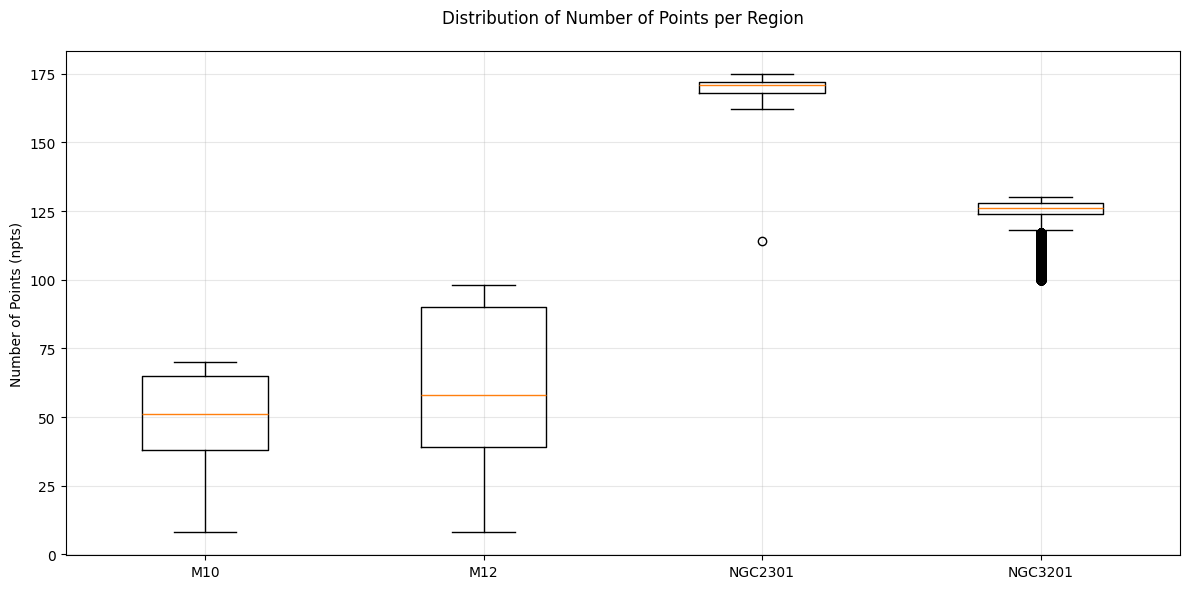

In [107]:
plt.figure(figsize=(12, 6))

npts_M10 = data[data['region_M10']]['npts']
npts_M12 = data[data['region_M12']]['npts']
npts_NGC2301 = data[data['region_NGC2301']]['npts']
npts_NGC3201 = data[data['region_NGC3201']]['npts']

box_data = [npts_M10, npts_M12, npts_NGC2301, npts_NGC3201]
plt.boxplot(box_data, labels=['M10', 'M12', 'NGC2301', 'NGC3201'])

plt.title('Distribution of Number of Points per Region', pad=20)
plt.ylabel('Number of Points (npts)')
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()


## EDA Highlight 2


### Distribution of Magnitudes by Regions

* gives interest in how different regions are distributed in terms of researching color brightness
* considering lower values of magnitude refers to higher brightness
* Difference between regions is visible data and it hides some information I guess

In [108]:
data.columns

Index(['ra', 'dec', 'starthjd', 'endhjd', 'vmag', 'verr', 'imag', 'ierr',
       'npts', 'region_M10', 'region_M12', 'region_NGC2301', 'region_NGC3201',
       'lcfil_I', 'lcfil_R', 'lcfil_V'],
      dtype='object')

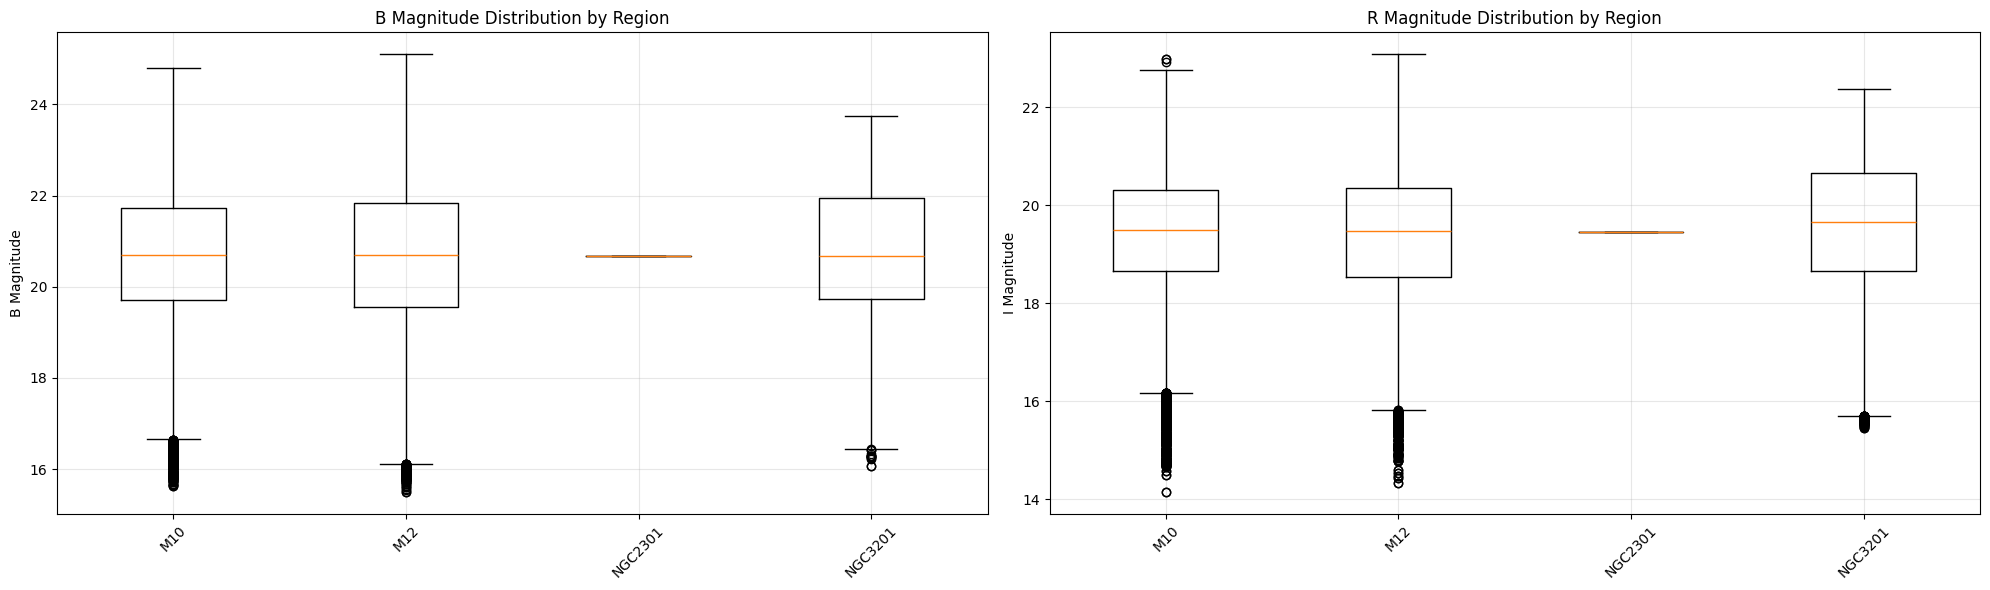

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

regions = ['M10', 'M12', 'NGC2301', 'NGC3201']

def get_data(data, mag_col):
    return [data[data[f'region_{region}']][mag_col] for region in regions]


bplot1 = ax1.boxplot(get_data(data, 'vmag'))
ax1.set_title('B Magnitude Distribution by Region')
ax1.set_xticklabels(regions, rotation=45)
ax1.set_ylabel('B Magnitude')
ax1.grid(True, alpha=0.3)

bplot2 = ax2.boxplot(get__data(data, 'imag'))the distribution is more even across the regions
ax2.set_title('R Magnitude Distribution by Region')
ax2.set_xticklabels(regions, rotation=45)
ax2.set_ylabel('I Magnitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

## EDA Highlight 3


### Distribution of number of points by brightness parameters

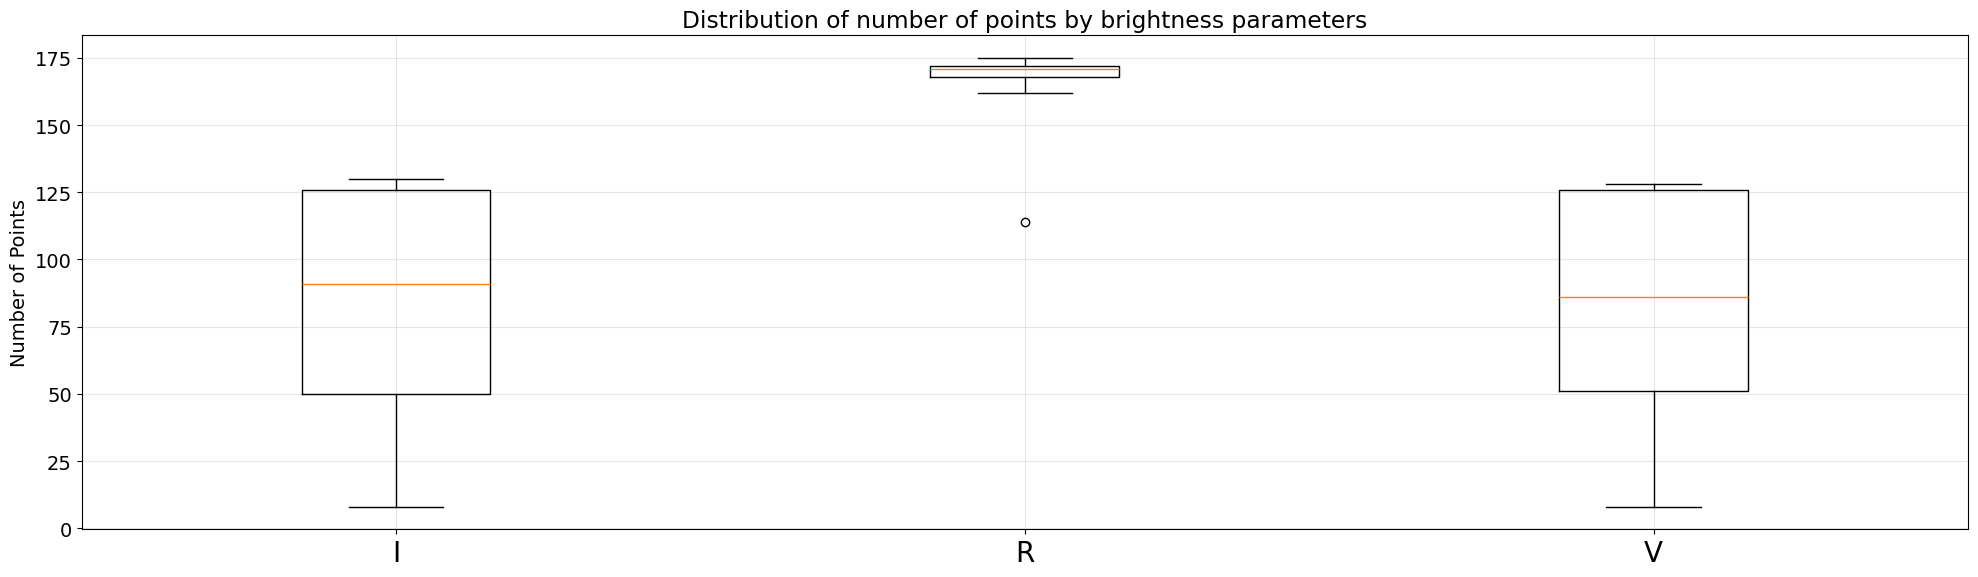

In [175]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

types = ['I', 'R', 'V']

def get_data(data, mag_col):
    return [data[data[f'lcfil_{type_}']][mag_col] for type_ in types]

plt.rcParams.update({'font.size': 14})

bplot1 = ax1.boxplot(get_data(data, 'npts'))
ax1.set_title('Distribution of number of points by brightness parameters')
ax1.set_xticklabels(types, fontsize=20)
ax1.set_ylabel('Number of Points')
ax1.grid(True, alpha=0.3)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



## EDA Highlight 4


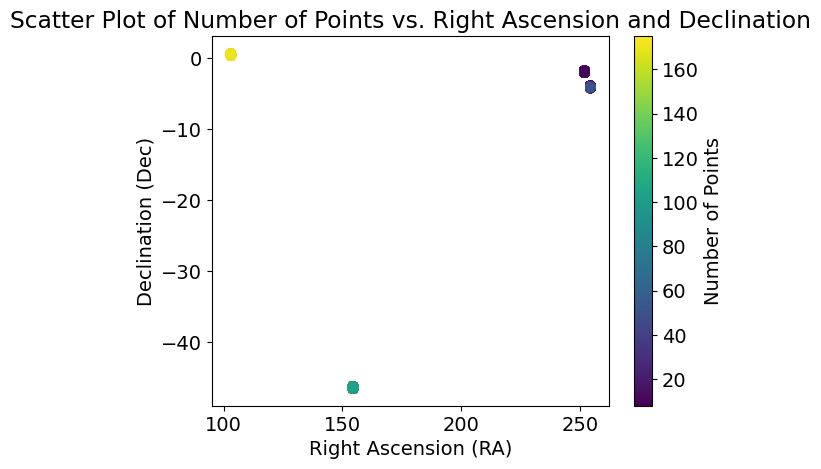

In [120]:
plt.scatter(data['ra'], data['dec'], c=data['npts'], cmap='viridis')
plt.colorbar(label='Number of Points')
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Scatter Plot of Number of Points vs. Right Ascension and Declination')
plt.show()
    

# Task 5 -- Dimensionality Reduction


<div class="alert alert-block alert-warning"> 
<b>PCA</b>: 
Conduct your analyses and transformations according to Task 5.
Call the transformed dataset "data_pca".

(Commented code + bullet points, add cells below)

</div>


# Task 6 -- Clustering


<div class="alert alert-block alert-warning"> 
<b>Choice of Algorithm</b>: 
Given the situation in the pitch and the results from the above analyses. Which algorithm (chosen from those discussed in the lectures) would YOU choose for the clustering? Explain!
    
(Choice + 1-3 bullet points in the cell below)
</div>


My Choice: ...

-


<div class="alert alert-block alert-danger"> 
<b>Requirements</b>: 
In the following and for the remainder of the final phase of the exam (indenpendent of what your choice above suggests), use

- a clustering algorithm $A$ chosen from the family: **k-means/k-means++**
- the evaluation metric $E_1$: **Silhouette Score**
- the evaluation metric $E_2$: **Davies-Bouldin Index**.
</div>


## Comprehensive clustering analysis

<div class="alert alert-block alert-warning"> 
<b>Clustering</b>: 
On both datasets, data and data_pca, under their respective headlines below, conduct comprehensive clustering analyses with algorithm $A$, using the available methodology from the module and specifically $E_1$ and $E_2$. Conduct ALL necessary steps to create the most helpful and meaningful clustering per dataset and discuss its quality. Use appropriate diagrams to demonstrate the results.

(Commented code + bullet points, add cells)

</div>


### Clustering Analysis of plain data


### Clustering Analysis of PCA transformed data


# Task 7 -- Clustering Comparison


<div class="alert alert-block alert-warning"> 
<b>Comparison</b>: 
Compare both clustering from the previous task as described in Task 7.

(Commented code + bullet points, add cells below)

</div>


# Task 8 -- Conclusions and Future Work

<div class="alert alert-block alert-warning"> 
<b>Subtasks</b>: 
For each subtask, create a fitting headline and add additional code and markdown cells below to conduct the respective task.
    
(Commented code + bullet points, add cells below)
</div>


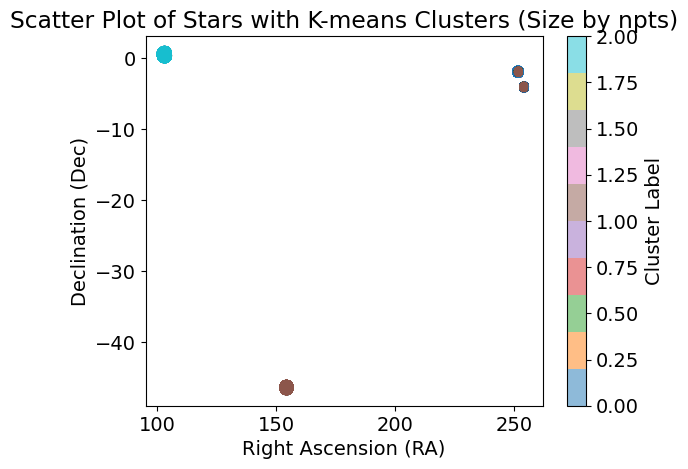

In [127]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare data for clustering (ra, dec, npts)
X = data

# Run K-means with 3 clusters (you can adjust this)
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

plt.scatter(data['ra'], data['dec'], c=data['cluster'], cmap='tab10', s=data['npts']*0.5, alpha=0.5)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Scatter Plot of Stars with K-means Clusters (Size by npts)')
plt.colorbar(label='Cluster Label')
plt.show()

In [129]:
data['dec'].unique()

array([ 0.4158,  0.4254,  0.4276, ..., -3.9378, -3.903 , -3.8988],
      shape=(14229,))

In [128]:
data['ra'].unique()

array([103.0431, 102.9154, 102.9629, ..., 254.1483, 254.1485, 254.1512],
      shape=(15676,))

In [130]:
unique_coords = data[['ra', 'dec']].drop_duplicates().shape[0]
print("Number of unique (ra, dec) pairs:", unique_coords)

# Check the full data
print("Total rows:", data.shape[0])

Number of unique (ra, dec) pairs: 103801
Total rows: 138935


In [131]:
data_aggregated = data.groupby(['ra', 'dec'])['npts'].mean().reset_index()

print("Shape after aggregating duplicates:", data_aggregated.shape)


from sklearn.cluster import KMeans

# Prepare data for clustering
X = data_aggregated[['ra', 'dec', 'npts']]

# Apply K-means
kmeans = KMeans(n_clusters=3, random_state=42)
data_aggregated['cluster'] = kmeans.fit_predict(X)

print("Number of cluster labels:", len(data_aggregated['cluster']))
print("Unique cluster labels:", data_aggregated['cluster'].unique())

Shape after aggregating duplicates: (103801, 3)
Number of cluster labels: 103801
Unique cluster labels: [2 0 1]


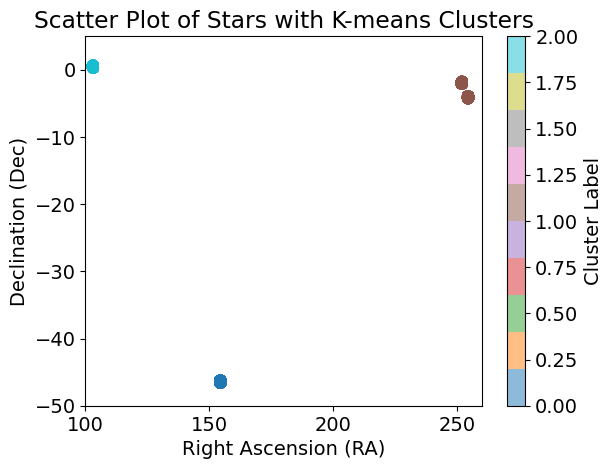

In [132]:
import matplotlib.pyplot as plt

# Scatter plot with clusters
plt.scatter(data_aggregated['ra'], data_aggregated['dec'], c=data_aggregated['cluster'], cmap='tab10', alpha=0.5, s=50)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Scatter Plot of Stars with K-means Clusters')
plt.colorbar(label='Cluster Label')
plt.xlim(100, 260)  # Based on ra range 102.75–254.49
plt.ylim(-50, 5)    # Based on dec range -46.61–0.69
plt.show()

In [133]:
print("Number of stars per cluster:", data_aggregated['cluster'].value_counts())

Number of stars per cluster: cluster
1    55509
0    44377
2     3915
Name: count, dtype: int64


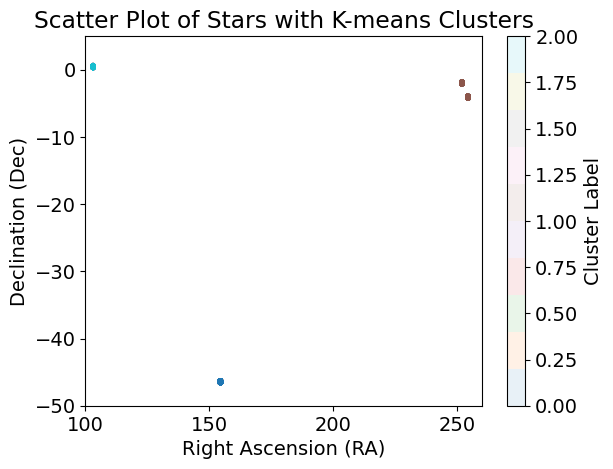

In [134]:
import matplotlib.pyplot as plt

# Scatter plot with adjustments
plt.scatter(data_aggregated['ra'], data_aggregated['dec'], c=data_aggregated['cluster'], cmap='tab10', alpha=0.1, s=5)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Scatter Plot of Stars with K-means Clusters')
plt.colorbar(label='Cluster Label')
plt.xlim(100, 260)  # Based on ra range 102.75–254.49
plt.ylim(-50, 5)    # Based on dec range -46.61–0.69
plt.show()

In [138]:
print("RA range:", data_aggregated['ra'].min(), "to", data_aggregated['ra'].max())
print("Dec range:", data_aggregated['dec'].min(), "to", data_aggregated['dec'].max())

RA range: 102.7501 to 254.4868
Dec range: -46.6116 to 0.6908


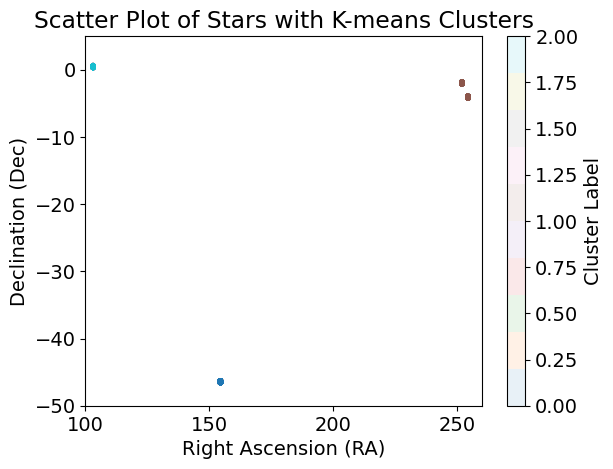

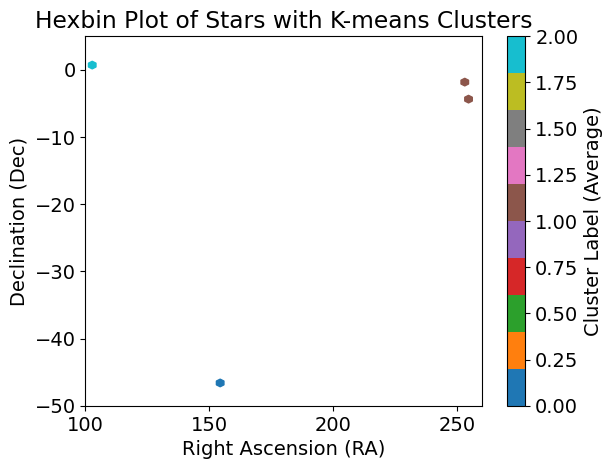

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Aggregate duplicates
data_aggregated = data.groupby(['ra', 'dec'])['npts'].mean().reset_index()

# Prepare data for clustering
X = data_aggregated[['ra', 'dec', 'npts']]

# Apply K-means
kmeans = KMeans(n_clusters=3, random_state=42)
data_aggregated['cluster'] = kmeans.fit_predict(X)

# Plot clusters
plt.scatter(data_aggregated['ra'], data_aggregated['dec'], c=data_aggregated['cluster'], cmap='tab10', alpha=0.1, s=5)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Scatter Plot of Stars with K-means Clusters')
plt.colorbar(label='Cluster Label')
plt.xlim(100, 260)
plt.ylim(-50, 5)
plt.show()

# Optional: Hexbin plot
plt.hexbin(data_aggregated['ra'], data_aggregated['dec'], C=data_aggregated['cluster'], cmap='tab10', gridsize=50)
plt.colorbar(label='Cluster Label (Average)')
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title('Hexbin Plot of Stars with K-means Clusters')
plt.xlim(100, 260)
plt.ylim(-50, 5)
plt.show()

Number of stars in NGC2301: 3915
Number of stars per cluster: cluster
27    80
21    77
39    76
17    75
1     75
      ..
6      1
41     1
3      1
87     1
46     1
Name: count, Length: 100, dtype: int64


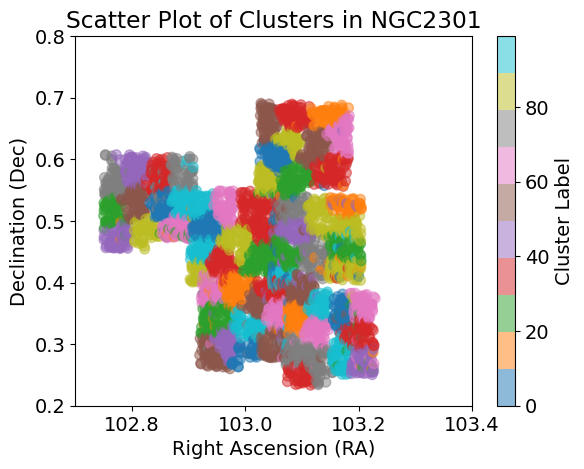

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Filter data for a specific region (e.g., NGC2301)
region_name = 'NGC2301'  # Change to 'M10', 'M12', or 'NGC3201' as needed
data_region = data[data['region_NGC2301']==True]

# Aggregate duplicates by averaging npts for the region
data_aggregated = data_region.groupby(['ra', 'dec'])['npts'].mean().reset_index()

# Prepare data for clustering
X = data_aggregated[['ra', 'dec', 'npts']]

# Apply K-means clustering (start with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
data_aggregated['cluster'] = kmeans.fit_predict(X)

# Print cluster distribution to check
print(f"Number of stars in {region_name}:", len(data_aggregated))
print("Number of stars per cluster:", data_aggregated['cluster'].value_counts())

# Scatter plot to visualize clusters
plt.scatter(data_aggregated['ra'], data_aggregated['dec'], c=data_aggregated['cluster'], cmap='tab10', alpha=0.5, s=50)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (Dec)')
plt.title(f'Scatter Plot of Clusters in {region_name}')
plt.colorbar(label='Cluster Label')
# plt.xlim(102.5, 103.5)  # Adjust based on your data range (102.75–254.49)
# plt.ylim(-2, 2)    # Adjust based on your data range (-46.61–0.69)
plt.xlim(102.7, 103.4)  # Example range for NGC2301
plt.ylim(0.20, 0.8)

plt.show()